### МАИ
### ФИО студента: Меркулов Лев Владимирович
### группа: Т120-101М-20
### ФИО руководителя: Джумурат Александр
### дата: 27.04.2021
### ДЗ № 8, ML в продакшне
### Москва, 2021 г.

# Домашнее задание : ML как http-сервис

## Задача 1: применяем PCA-трансформацию

Модифицируйте файл `train.py` - добавьте в пайплайн обучения модели сжатие размерности до `n_components=2` с помощью [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и обучите модель **в докере** на "сжатых" данных. Сохраните полученный объект `pca_transformer.pkl`, который умеет выполнять сжатие данных.

Решением домашки считается модифицированный файл *train.py*

In [33]:
# --- ВАШ КОД ТУТ --
import pickle
import os
import logging
from pathlib import Path

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

LOG_FORMAT = '%(asctime)s | %(levelname)-8s | %(filename)-25.25s:%(lineno)-4d | %(message)s'

log_filename = "/www/classifier/data/service.log"
logging.basicConfig(level=logging.INFO, format=LOG_FORMAT)

def load_data(from_file: Path):
    data_source = np.genfromtxt(from_file.resolve().as_posix(), delimiter=',', skip_header=1)
    X = data_source[:, :3]
    y = data_source[:, 3]
    
    return X, y

def transform(X, path: Path):
    pca_transformer = PCA(n_components=2).fit(X)
    X_pca = pca_transformer.transform(X)
    
    if not os.path.exists(path.resolve()):
        logging.info('PCA ещё не сохранен')
        with path.open('wb') as f:
            pickle.dump(pca_transformer, f)
            logging.info('PCA Transformer обучен и сохранен в %s' % path.resolve())
    else:
        logging.info('PCA уже обучен и сохранен в %s' % path.resolve())    
    return X_pca


def classify(X, y, path: Path): 
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    clf.fit(X, y)

    if not os.path.exists(path.resolve()):
        logging.info('Модель ещё не сохранена')
        with path.open('wb') as f:
            pickle.dump(clf, f)
            logging.info('Модель обучена и сохранена в %s' % path.resolve())
    else:
        logging.info('Модель уже обучена и сохранена в %s' % path.resolve())

def train():
    X, y = load_data(Path('data/client_segmentation.csv'))
    X = transform(X, path=Path('./data/pca_transformer.pkl'))

    classify(X, y, path=Path('./data/clf.pkl'))

train()

# ------------------

2021-04-27 16:39:23,099 | INFO     | <ipython-input-33-28f40d0:29   | PCA Transformer обучен и сохранен в /home/lev/Desktop/data_management/pca_transformer.pkl
2021-04-27 16:39:23,108 | INFO     | <ipython-input-33-28f40d0:40   | Модель обучена и сохранена в /home/lev/Desktop/data_management/clf.pkl


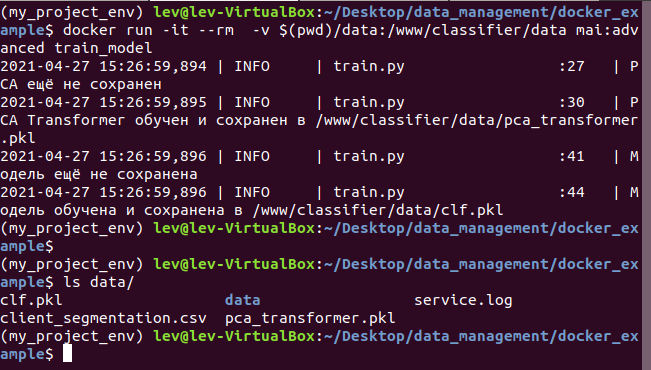

## Задача 2: трансформация входных фичей на лету

Модифицируйте файл `service.py`: добавьте загрузку объекта для трансформации `pca_tansformer.pkl` и применяйте её **в докере** для трансформации набора входных фич в сжатые (см. метод `.transform()`):
<pre>
[x1, x2, x3] -> [x1_pca, x2_pca]
</pre>

Соответственно, predict надо выполнять на *сжатых* фичах


Решением домашки считается модифицированный файл *service.py*

In [74]:
# --- ВАШ КОД ТУТ --
"""
Умеет выполнять классификацию клиентов по трём фичам

Запускаем из python3:
    python3 service.py
Проверяем работоспособность:
    curl http://127.0.0.1:5000/
"""
import json
import http.server
import logging
import os
import pickle
import socketserver
import sys
from http import HTTPStatus
from re import compile
from pathlib import Path

import numpy as np
from sklearn.tree import DecisionTreeClassifier

# файл, куда посыпятся логи модели

LOG_FORMAT = '%(asctime)s | %(levelname)-8s | %(filename)-25.25s:%(lineno)-4d | %(message)s'

#log_filename = "/www/classifier/data/service.log"
logging.basicConfig(level=logging.INFO, format=LOG_FORMAT)


def parse_params(params) -> dict:
    """
        Выдираем параметры из GET-запроса
    """
    params_list = params.split('&')
    params_dict = {'x1': None, 'x2': None, 'x3': None}
    for param in params_list:
        key, value = param.split('=')
        params_dict[key] = float(value)
    return params_dict


class Handler(http.server.SimpleHTTPRequestHandler):
    """Простой http-сервер"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_response(self) -> dict:
        """Пример запроса
        
        http://0.0.0.0:5000/classifier/?x1=1&x2=-2.2&x3=1.05
        """
        response = {'ping': 'ok'}
        params_parsed = self.path.split('?')
        
        if len(params_parsed) == 2 and self.path.startswith('/classifier'):
            params = params_parsed[1]
            params_dict = parse_params(params)
            response = params_dict
            
            user_features = np.array(
                [[params_dict['x1'],
                 params_dict['x2'], 
                 params_dict['x3']]]
            )
            
            #применим pca_transform
            reduced_features = transformer.transform(user_features)
            
            predicted_class = int(classifier_model.predict(reduced_features)[0])
            
            logging.info('predicted_class %s' % predicted_class)
            response.update({'predicted_class': predicted_class})
        
        elif self.path.startswith('/ping/'):
            response = {'message': 'pong'}

        return response

    def do_GET(self):
        # заголовки ответа
        self.send_response(HTTPStatus.OK)
        self.send_header("Content-type", "application/json")
        self.end_headers()
        self.wfile.write(json.dumps(self.get_response()).encode())


logging.info('Загружаем обученную модель')
with open('./data/clf.pkl', 'rb') as f:
    classifier_model = pickle.load(f)
    logging.info('Модель загружена: %s' % classifier_model)

with open('./data/pca_transformer.pkl', 'rb') as f:
    transformer = pickle.load(f)
    logging.info('PCA transformer загружен: %s' % transformer)

#if __name__ == '__main__':
#    classifier_service = socketserver.TCPServer(('', 5000), Handler)
#    classifier_service.serve_forever()

# ------------------

## Задача 3: Используем Flask

Перепишите сервис на использование Flask. Вы можете взять готовый базовый образ с Flask, либо добавить установку в тот контейнер, который есть - это нужно сделать в Dockerfile

Задача необязательная, для успешного выполнения домашки достаточно первых двух пунктов

In [51]:
# --- ВАШ КОД ТУТ --
from flask import Flask, jsonify, request
import logging
import pickle

app = Flask(__name__)

@app.route('/ping', methods=['GET'])
def ping():
    msg = {'message': 'pong'}
    response = jsonify(msg)
    return response

@app.route('/classifier', methods=['GET'])
def classify():
    """Пример запроса
    http://0.0.0.0:5000/classifier/?x1=1&x2=-2.2&x3=1.05
    """
    response = {'ping': 'ok'}
    
    x1 = request.args.get('x1', type=float)
    x2 = request.args.get('x2', type=float)
    x3 = request.args.get('x3', type=float)
    
    user_features = np.array([[x1, x2, x3]])
            
    #применим pca_transform
    reduced_features = transformer.transform(user_features)

    predicted_class = int(classifier_model.predict(reduced_features)[0])
    
    response = {'x1': x1, 'x2': x2, 'x3': x3}
    response.update({'predicted_class': predicted_class})
    
    logging.info('predicted_class %s' % predicted_class)
        
    return jsonify(response)

@app.errorhandler(404)
def page_not_found(e):
    return jsonify({'message': 'pong'})

logging.info('Загружаем обученную модель')
with open('./data/clf.pkl', 'rb') as f:
    classifier_model = pickle.load(f)
    logging.info('Модель загружена: %s' % classifier_model)

with open('./data/pca_transformer.pkl', 'rb') as f:
    transformer = pickle.load(f)
    logging.info('PCA transformer загружен: %s' % transformer)
    
if __name__ == "__main__":
    LOG_FORMAT = '%(asctime)s | %(levelname)-8s | %(filename)-25.25s:%(lineno)-4d | %(message)s'
    logging.basicConfig(level=logging.INFO, format=LOG_FORMAT)
    #app.run(port=5001)


# ------------------

2021-04-27 20:24:12,617 | INFO     | <ipython-input-51-279bd3d:39   | Загружаем обученную модель
2021-04-27 20:24:12,619 | INFO     | <ipython-input-51-279bd3d:42   | Модель загружена: DecisionTreeClassifier(max_depth=3, random_state=42)
2021-04-27 20:24:12,621 | INFO     | <ipython-input-51-279bd3d:46   | PCA transformer загружен: PCA(n_components=2)


# Домашнее задание: рекомендательная система

## Задача 1: строим KNN

В реальной жизни KNN-рекомендатель не стоит делать на основе `sklearn.neighbors.NearestNeighbors` - есть готовые реализации, заточенные специально для построения рекомендательных систем. Хорошим примером такой реализации является [пакет implictit](). В рамках домашней работы предлагается разобраться с реализацией KNN-рекомендателя из этой библиотеки 

Почитайте документацию по модулю `implicit.nearest_neighbours.CosineRecommender`. Обучите KNN-рекомендатель и воспользуйтесь методом `recommend` для построения рекомендаций


In [3]:
import pandas as pd
import numpy as np

content_views = pd.read_csv(
    'recsys_data/content_views.zip', delimiter=',', header=0, compression='zip',
    names = ['user_id', 'content_id', 'view_duration', 'view_ts', 'dt', 'platform'],
    dtype = {'user_id': np.uint32, 'content_id': np.uint16, 'view_duration': np.uint16},
    parse_dates = [3, 4]
)


print('Количество просмотров %s' % content_views.user_id.count())

content_views.head(3)

Количество просмотров 489565


,user_id,content_id,view_duration,view_ts,dt,platform
0,4649,52867,735,2019-03-18 20:40:57+03:00,2019-03-18,LG
1,16,48800,361,2019-03-18 11:48:27+03:00,2019-03-18,LG
2,5380,47146,268,2019-02-17 13:06:33+03:00,2019-02-17,LG


In [4]:
content_description = pd.read_csv(
    'recsys_data/content_description.zip', delimiter=',', header=0, compression='zip',
    names = ['content_id', 'origin_country', 'release_date', 'kinopoisk_rating', 'compilation_id', 'genre'],
    dtype = {'content_id': np.uint16},
    parse_dates = [2]
)

print('Количество доступного контента %s' % content_description.content_id.count())

content_description.head(3)

Количество доступного контента 126182


,content_id,origin_country,release_date,kinopoisk_rating,compilation_id,genre
0,1974,87.0,2009-12-15,7.27,153,Для детей
1,2148,87.0,2009-12-21,7.27,153,Для детей
2,2184,87.0,2009-12-22,7.27,153,Для детей


In [5]:
from sklearn.preprocessing import LabelEncoder

# кодируем индексы пользователей
user_encoder = LabelEncoder()
user_encoder.fit(content_views.user_id)

# ереиндексация контента
content_views = content_views.assign(
    user_index = user_encoder.transform(content_views.user_id)
)

# кодируем индексы контента
item_encoder = LabelEncoder()
item_encoder.fit(content_views.content_id)

# нова переиндексация
content_views = content_views.assign(
    item_index = item_encoder.transform(content_views.content_id)
)


content_views.head()

,user_id,content_id,view_duration,view_ts,dt,platform,user_index,item_index
0,4649,52867,735,2019-03-18 20:40:57+03:00,2019-03-18,LG,802,22812
1,16,48800,361,2019-03-18 11:48:27+03:00,2019-03-18,LG,2,20399
2,5380,47146,268,2019-02-17 13:06:33+03:00,2019-02-17,LG,911,19628
3,4498,30191,297,2019-03-18 15:27:18+03:00,2019-03-18,LG,773,13517
4,4886,39349,302,2019-03-18 12:08:16+03:00,2019-03-18,LG,836,16959


In [6]:
from scipy.sparse import csr_matrix

num_users = content_views.user_index.max() + 1
num_items = content_views.item_index.max() + 1
num_interactions = content_views.shape[0]

user_item = csr_matrix(
    (np.ones(num_interactions),(content_views.user_index.values, content_views.item_index.values)),
    shape=(num_users, num_items)
)
print('sparsity: %.4f' % (num_interactions / (num_users * num_items)))

user_item

sparsity: 0.0091


<2000x27012 sparse matrix of type '<class 'numpy.float64'>'
	with 259994 stored elements in Compressed Sparse Row format>

In [7]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(
    np.arange(start=0, stop=user_item.shape[0], step=1, dtype=np.uint32),
    test_size=0.2
)
print(
    """
        Размер обучающей выборки %d пользователей
        Размер валидационной выборки %d пользователей
    """
    % (train_ids.size, test_ids.size)
)


        Размер обучающей выборки 1600 пользователей
        Размер валидационной выборки 400 пользователей
    


In [8]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# обучаемся только на тренировочной части пользователей
model_knn.fit(user_item[train_ids,:])

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [9]:
class ColaborativeFilteringKNNRecommender:
    def __init__(self, knn_model, user_item_matrix, num_neighbors):
        self.knn_model = knn_model
        self.user_item_matrix = user_item_matrix
        self.num_neighbors = num_neighbors
        self.top_recs = 50
    
    def make_recs(self, user_history: csr_matrix, top_recs: int):
        neighbors = model_knn.kneighbors(
            random_user_history,
            self.num_neighbors,
            return_distance=False
        )[0]
        full_recs = user_item[neighbors,:].max(axis=0)
        # рекомендации - это то, что насмотрели ближайшие соседи
        user_history_ids = user_history.nonzero()[1]
        # последовательность id того контента, который смотрели ближайшие соседи
        full_recs_ids = full_recs.nonzero()[1][:self.top_recs]
        # исключаем из рекомендаций то, что уже было у упользователя в историии
        success_recs = np.array([i for i in full_recs_ids if i in user_history_ids])
        print("Число успешных рекомендаций %d из %d" % (success_recs.size, top_recs))
        
        return np.array([i for i in full_recs_ids if i not in user_history_ids])[:10]


# объект рекомендателя
recommender = ColaborativeFilteringKNNRecommender(
    knn_model=model_knn,
    user_item_matrix=user_item,
    num_neighbors=10
)

In [10]:
# пример рекомендаций для случайного пользователя
random_user_index = 237
random_user_history = user_item.getrow(random_user_index).reshape(1, -1)

recs = recommender.make_recs(random_user_history, top_recs=10)
print('user_index %d, history: %s' % (random_user_index, random_user_history.nonzero()[1][:10]))
print('recommendations: %s' % recs)

Число успешных рекомендаций 2 из 10
user_index 237, history: [ 88  94 115 558 660 661 662 663 664 665]
recommendations: [50 51 52 53 54 55 56 57 76 79]


Хорошим примером такой реализации является пакет implictit. В рамках домашней работы предлагается разобраться с реализацией KNN-рекомендателя из этой библиотеки

Почитайте документацию по модулю implicit.nearest_neighbours.CosineRecommender. Обучите KNN-рекомендатель и воспользуйтесь методом recommend для построения рекомендаций

In [11]:
# -- ВАШ КОД ТУТ --

from implicit.nearest_neighbours import CosineRecommender

cosine_recommender = CosineRecommender(K=50, num_threads=0)
cosine_recommender.fit(user_item[train_ids,:])

cosine_recommender.recommend(random_user_index, user_item[train_ids,:])

# ------------------

  0%|          | 0/1600 [00:00<?, ?it/s]

[(1157, 1.0), (581, 0.0)]

## Задача 2: Item to Item

Решите задачу c2c рекомендаций - вызовите метод `similar_items` для  *item_id=1*

In [12]:
# -- ВАШ КОД ТУТ --

cosine_recommender.similar_items(1)

# ------------------

[(1, 1.0),
 (983, 1.0),
 (1440, 0.028295591748714637),
 (1300, 0.028182994438777077)]

## Задача 3: обучаем Implicit

Почитайте документацию по модулю implicit.als.AlternatingLeastSquares. Обучите ALS-рекомендатель и воспользуйтесь методом recommend для построения рекомендаций

In [13]:
# -- ВАШ КОД ТУТ --

from implicit.als import AlternatingLeastSquares

als_recommender = AlternatingLeastSquares()
als_recommender.fit(user_item[train_ids,:])

als_recommender.recommend(random_user_index, user_item[train_ids,:])

# -----------------

  0%|          | 0/15 [00:00<?, ?it/s]

[(892, 1.2012565),
 (832, 1.173341),
 (466, 1.1614776),
 (544, 1.1396991),
 (1128, 1.1374464),
 (1260, 1.1323302),
 (1435, 1.1318253),
 (170, 1.1193284),
 (683, 1.1156464),
 (417, 1.106951)]

## Задача 4: реализация метрик

Даны два вектора - истинная история пользователя и объекты, которые считает релеватными ваша модель

Вычислите

* precision
* recall
* precision@5


![eval](img/eval.png)

**Recall**  показывает отношение товаров, купленных из рекомендаций к общему числу фактических просмотров

$$
\text{recall} = \frac{m}{k} = \frac{2}{3}
$$

**Precision**  показывает, насколько много из рекомендованного нами попало в итоге в просмотренное

$$
\text{precision} = \frac{m}{n} = \frac{2}{5}
$$

У precision заметен один недостаток - игнорируется порядок, в котором пользователя заинтересовали рекомендованные объекты. Эту задачу решает метрика *average precision at K*. В числителе дисконтируем каждую "единичку", на ту позицию, где она стоит:

$$
\text{ap} = \frac{1}{5}\left( 0 + \frac{1}{2} + \frac{1}{3}\right) = \frac{1}{5}\cdot \frac{5}{6} = \frac{1}{6}
$$

при такой модификации мы заставляем модель не просто угадывать релевантные объекты, но и "поднимать" их выше к началу списка

In [73]:
import numpy as np

user_interactions = [47315, 30004, 36322,  8942, 30820,  6086,  9126,   332, 16289,
       39106, 39335, 48506, 48654,  9234, 29935,  2678, 36202, 22636, 18007, 39328, 15414, 30016, 35601,
    58409, 21313,   386, 16303, 4397, 19644, 51887, 21659, 36325, 53030,  7764, 50266, 58734, 53419, 24121,
    50806, 36092,  8868, 28037, 36131, 13561, 16298, 27508, 41722, 30189, 46490,  2676, 43328, 781, 48397,
    41369, 39324, 36381, 39635, 27710, 47837, 28525, 12024, 56604, 41664, 37387, 48507, 413, 33526, 20059,
    49781, 56648, 16283, 50805, 34254, 39325, 59374, 22620,  8865, 27512, 13875, 30011,  7621,
    10544, 28076, 29716, 30054, 20490, 29466, 16852, 39363, 34250, 7024, 33541,   263, 21267, 25690, 23020,
    41368, 53414,  2681, 30201] 

user_recs = [
    50820, 27781, 36131, 50812, 36092, 12024, 59155, 30042, 15414, 19882, 21659, 27849, 39328, 34240, 2681,
    21267, 50126, 58560, 7764, 49781
]

# --- ВАШ КОД ТУТ ---

def get_precision_at_n(n, crossing_set, user_intercations):
    result = 0
    for x in np.nditer(crossing_set):
        result += 1/(user_interactions.index(x)+1)
    return result/n

crossing = np.intersect1d(user_recs, user_interactions)

recall = len(crossing)/len(user_interactions)
precision = len(crossing)/len(user_recs)
precision_5 = get_precision_at_n(5, crossing, user_interactions)

print(f'recall:{recall}, precision:{precision}, precision@5:{precision_5}')
# -------------------

recall:0.1, precision:0.5, precision@5:0.05183403900280743
